The purpose of this notebook is to check to make sure our data processing pipeline works.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'


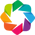

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import loren_frank_data_processing as lfdp
import spectral_connectivity
import ripple_detection
import replay_classification

import logging
logging.basicConfig(level=logging.INFO)

## Task Data

Make sure we can get information about the experimental setup

In [3]:
from src.parameters import ANIMALS

epoch_info = lfdp.make_epochs_dataframe(ANIMALS)
epoch_info

environment   type  exposure
animal day epoch                                    
JZ1    1   1                  sleep  sleep       NaN
           2                 wtrack    run       1.0
           3                  sleep  sleep       NaN
           4                 wtrack    run       2.0
           5                  sleep  sleep       NaN
           6              openfield    run       1.0
           7                  sleep  sleep       NaN
           8              openfield    run       2.0
           9                  sleep  sleep       NaN
       2   1                  sleep  sleep       NaN
           2                 wtrack    run       3.0
           3                  sleep  sleep       NaN
           4                 wtrack    run       4.0
           5                  sleep  sleep       NaN
           6              openfield    run       3.0
           7                  sleep  sleep       NaN
           8              openfield    run       4.0
           9                  sleep  sleep       NaN
       3   1                  sleep  sleep       NaN
           2                 wtrack    run       5.0
           3                  sleep  sleep       NaN
           4                 wtrack    run       6.0
           5                  sleep  sleep       NaN
           6              openfield    run       5.0
           7                  sleep  sleep       NaN
           8              openfield    run       6.0
           9                  sleep  sleep       NaN
       4   1                  sleep  sleep       NaN
           2                 wtrack    run       7.0
           3                  sleep  sleep       NaN
...                             ...    ...       ...
       11  7                  sleep  sleep       NaN
           8              openfield    run      22.0
           9                  sleep  sleep       NaN
       12  1                  sleep  sleep       NaN
           2      sixarmtrack_right    run       5.0
           3                  sleep  sleep       NaN
           4      sixarmtrack_right    run       6.0
           5                  sleep  sleep       NaN
           6              openfield    run      23.0
           7                  sleep  sleep       NaN
           8              openfield    run      24.0
           9                  sleep  sleep       NaN
       13  1                  sleep  sleep       NaN
           2      sixarmtrack_right    run       7.0
           3                  sleep  sleep       NaN
           4      sixarmtrack_right    run       8.0
           5                  sleep  sleep       NaN
           6              openfield    run      25.0
           7                  sleep  sleep       NaN
           8              openfield    run      26.0
           9                  sleep  sleep       NaN
       14  1                  sleep  sleep       NaN
           2      sixarmtrack_right    run       9.0
           3                  sleep  sleep       NaN
           4      sixarmtrack_right    run      10.0
           5                  sleep  sleep       NaN
           6              openfield    run      27.0
           7                  sleep  sleep       NaN
           8              openfield    run      28.0
           9                  sleep  sleep       NaN

[126 rows x 3 columns]

In [4]:
epoch_key = ('JZ1', 1, 2)

## Position Data
Make sure we can get the 2D and linear position

In [12]:
position_info = lfdp.get_interpolated_position_dataframe(
    epoch_key, ANIMALS, max_distance_from_well=5)
position_info.head()

labeled_segments from_well to_well task is_correct  \
time                                                                  
00:28:00.085200               1.0       NaN     NaN  NaN        NaN   
00:28:00.085867               1.0       NaN     NaN  NaN        NaN   
00:28:00.086534               1.0       NaN     NaN  NaN        NaN   
00:28:00.087201               1.0       NaN     NaN  NaN        NaN   
00:28:00.087868               1.0       NaN     NaN  NaN        NaN   

                 x_position  y_position  head_direction     speed  \
time                                                                
00:28:00.085200   47.223078   51.476199       -3.077704  5.142901   
00:28:00.085867   47.223078   51.476199       -3.077704  5.142901   
00:28:00.086534   47.223078   51.476199       -3.077704  5.142901   
00:28:00.087201   47.223078   51.476199       -3.077704  5.142901   
00:28:00.087868   47.223078   51.476199       -3.077704  5.142901   

                 linear_distance  
time                              
00:28:00.085200        42.241868  
00:28:00.085867        42.241868  
00:28:00.086534        42.241868  
00:28:00.087201        42.241868  
00:28:00.087868        42.241868

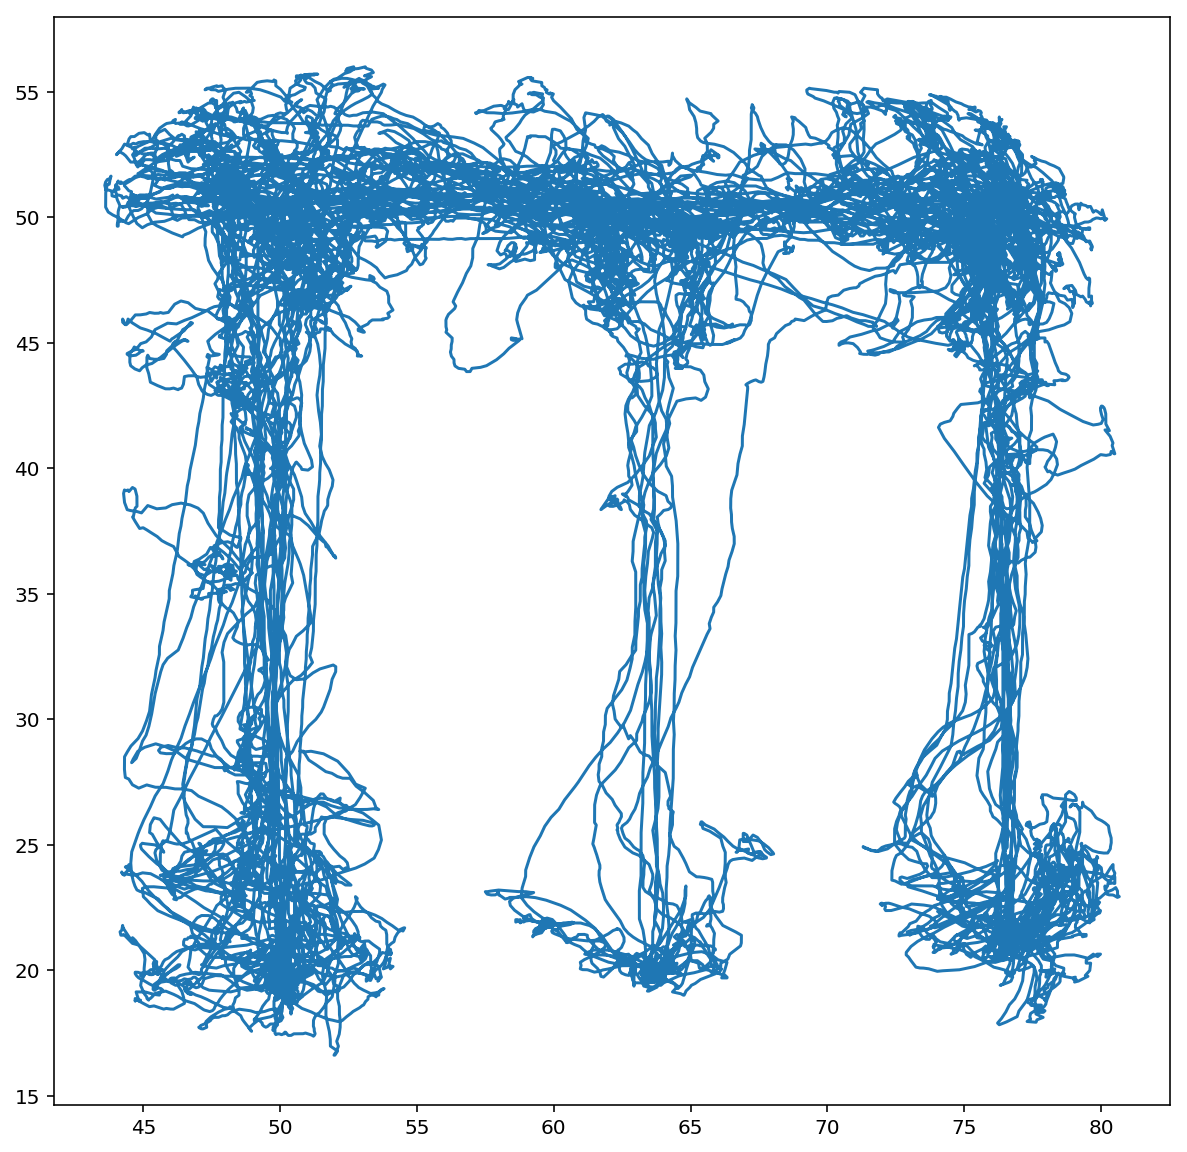

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(position_info.x_position.values, position_info.y_position.values);

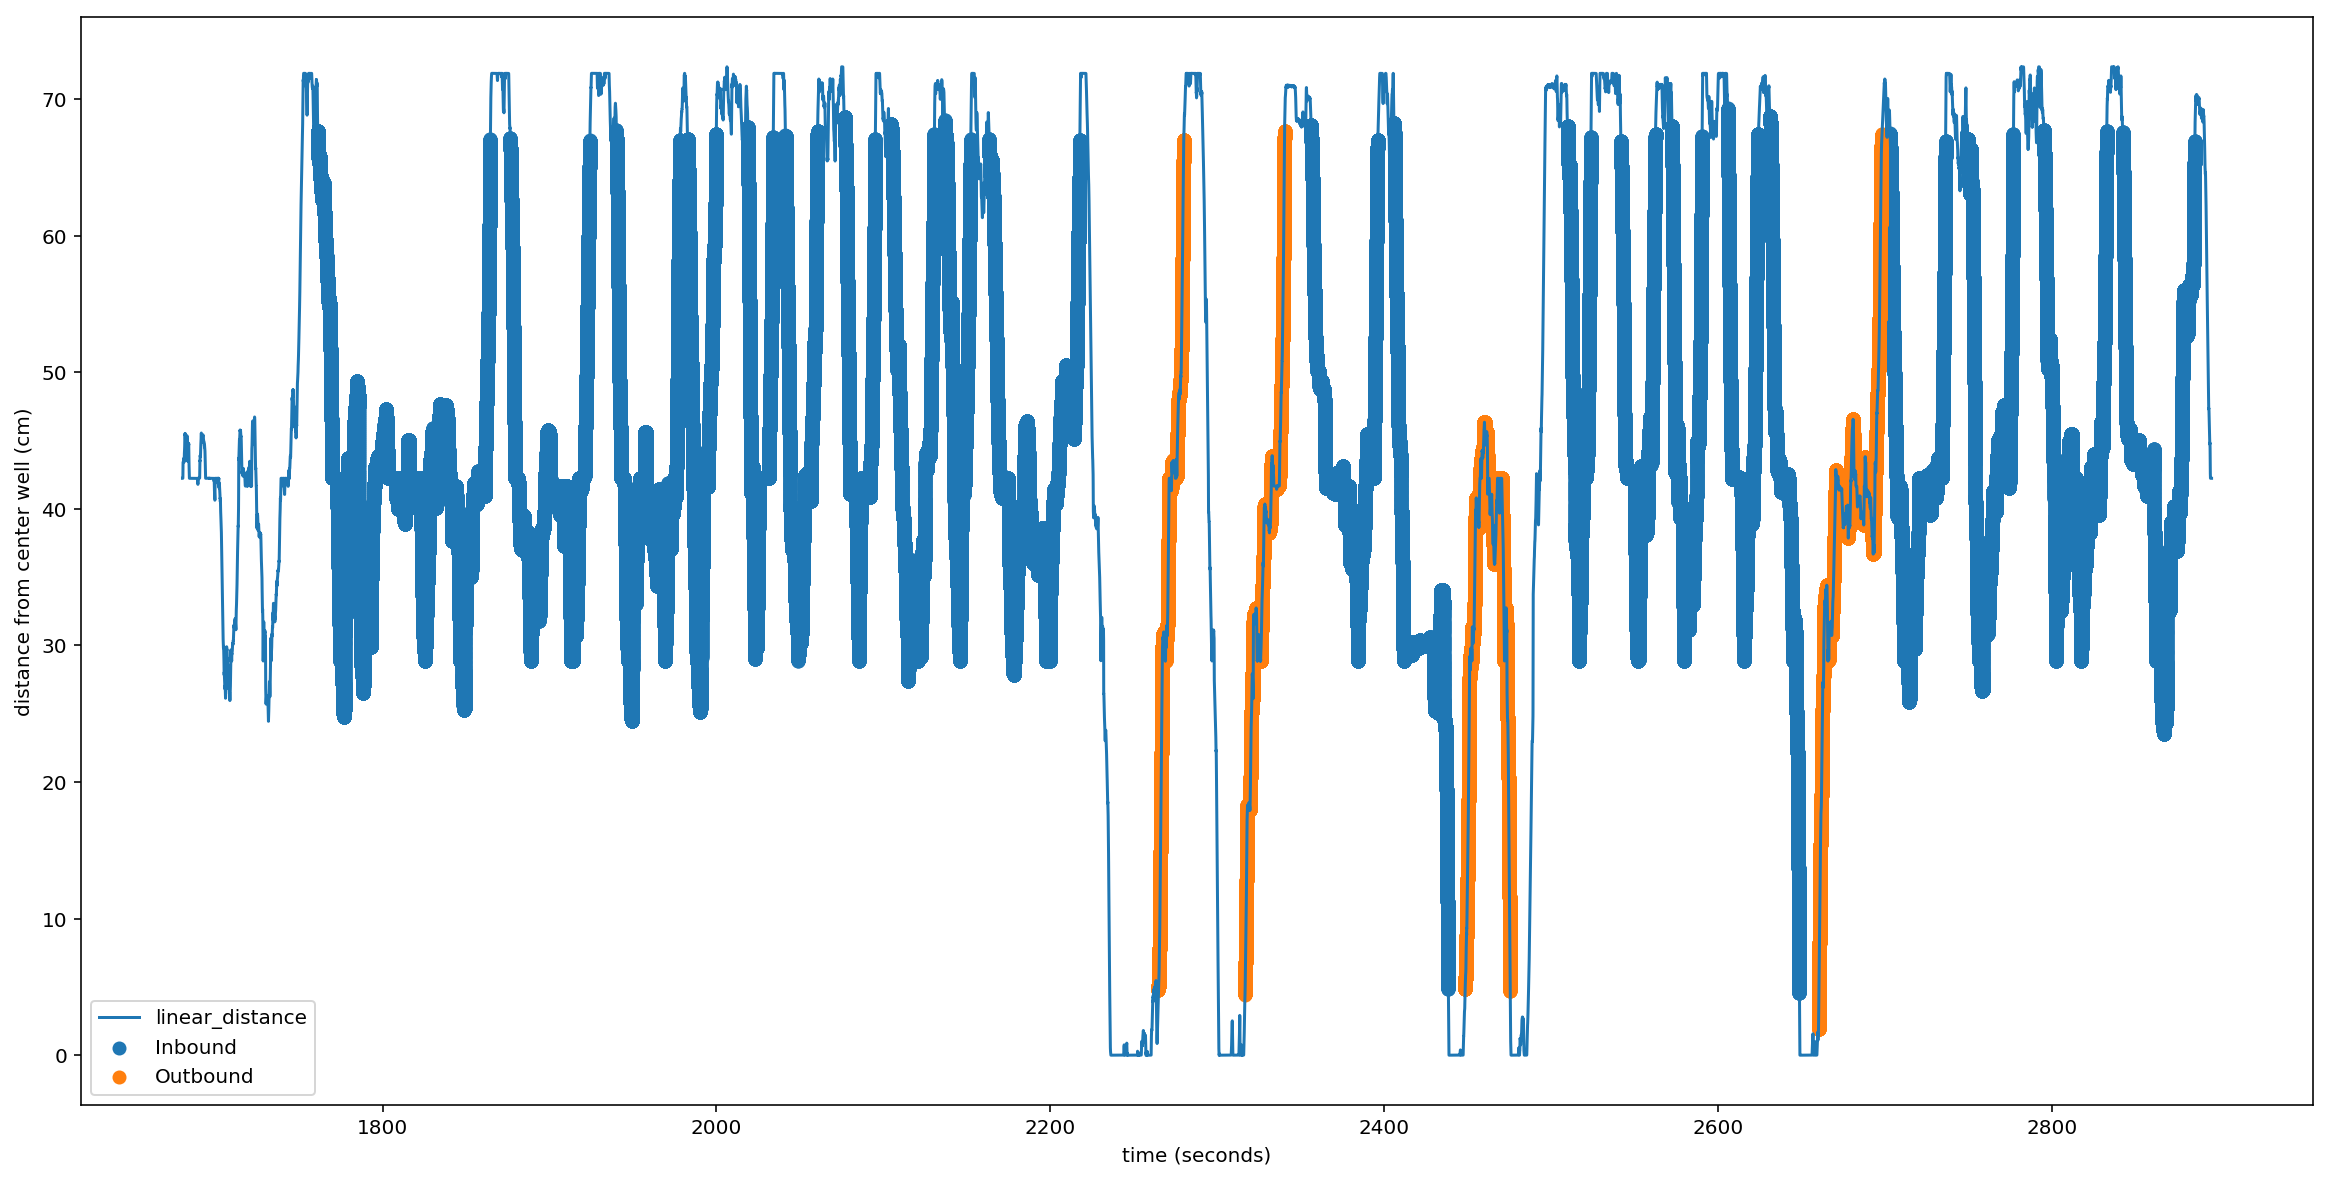

In [14]:
plt.figure(figsize=(20, 10))

plt.plot(position_info.index.total_seconds(), position_info.linear_distance)

for label, df in position_info.groupby('task'):
    plt.scatter(df.index.total_seconds(), df.linear_distance, label=label)

plt.xlabel('time (seconds)')
plt.ylabel('distance from center well (cm)')
plt.legend();

3


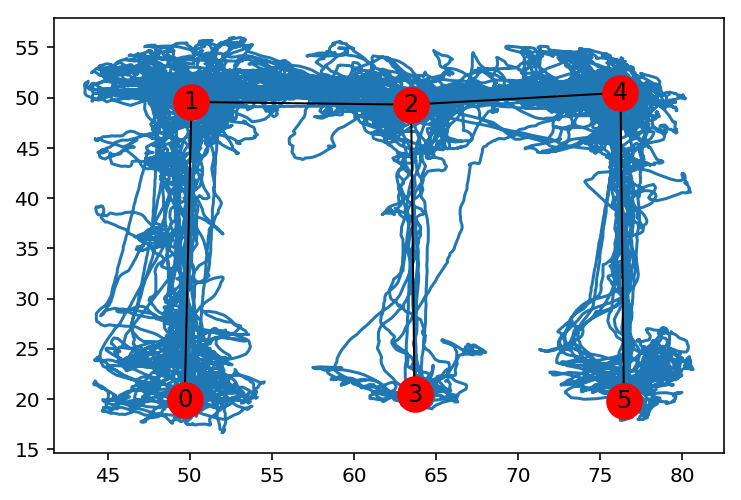

In [128]:
track_graph, center_well_id = lfdp.position.make_track_graph(epoch_key, ANIMALS)
plt.plot(position_info.x_position.values, position_info.y_position.values, zorder=-1);
lfdp.track_segment_classification.plot_track(track_graph, ax=None)

print(center_well_id)

In [110]:
position_df = lfdp.position.get_position_dataframe(epoch_key, ANIMALS)
position = position_df.loc[:, ['x_position', 'y_position']].values
track_segment_id = lfdp.track_segment_classification.classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=1E-1)


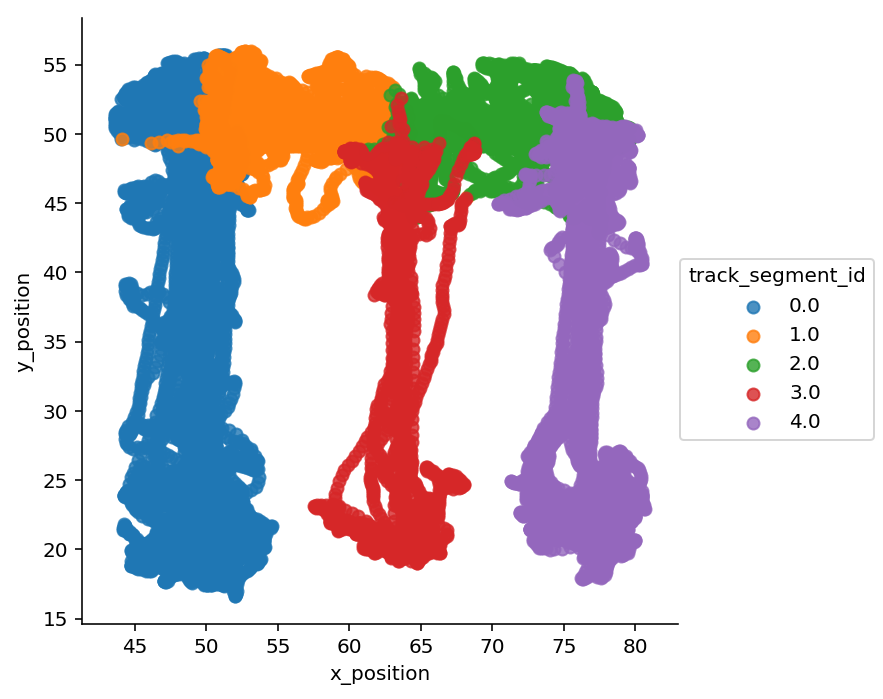

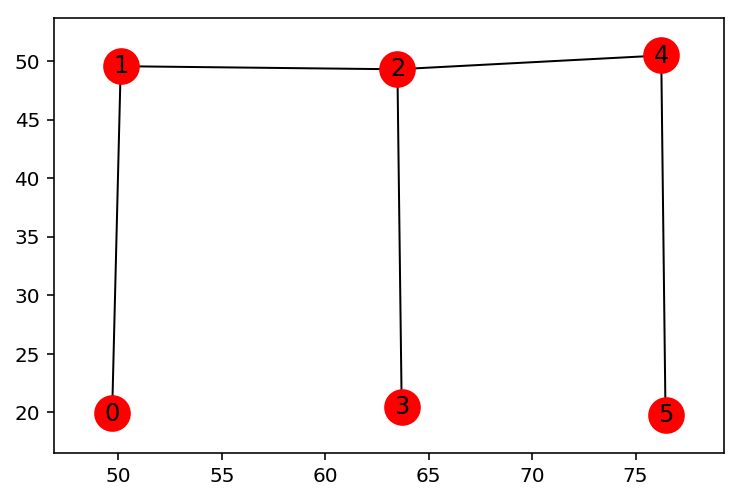

In [129]:
position_df['track_segment_id'] = track_segment_id
sns.lmplot('x_position', 'y_position', data=position_df , hue='track_segment_id', fit_reg=False)

plt.figure()
lfdp.track_segment_classification.plot_track(track_graph, ax=None)

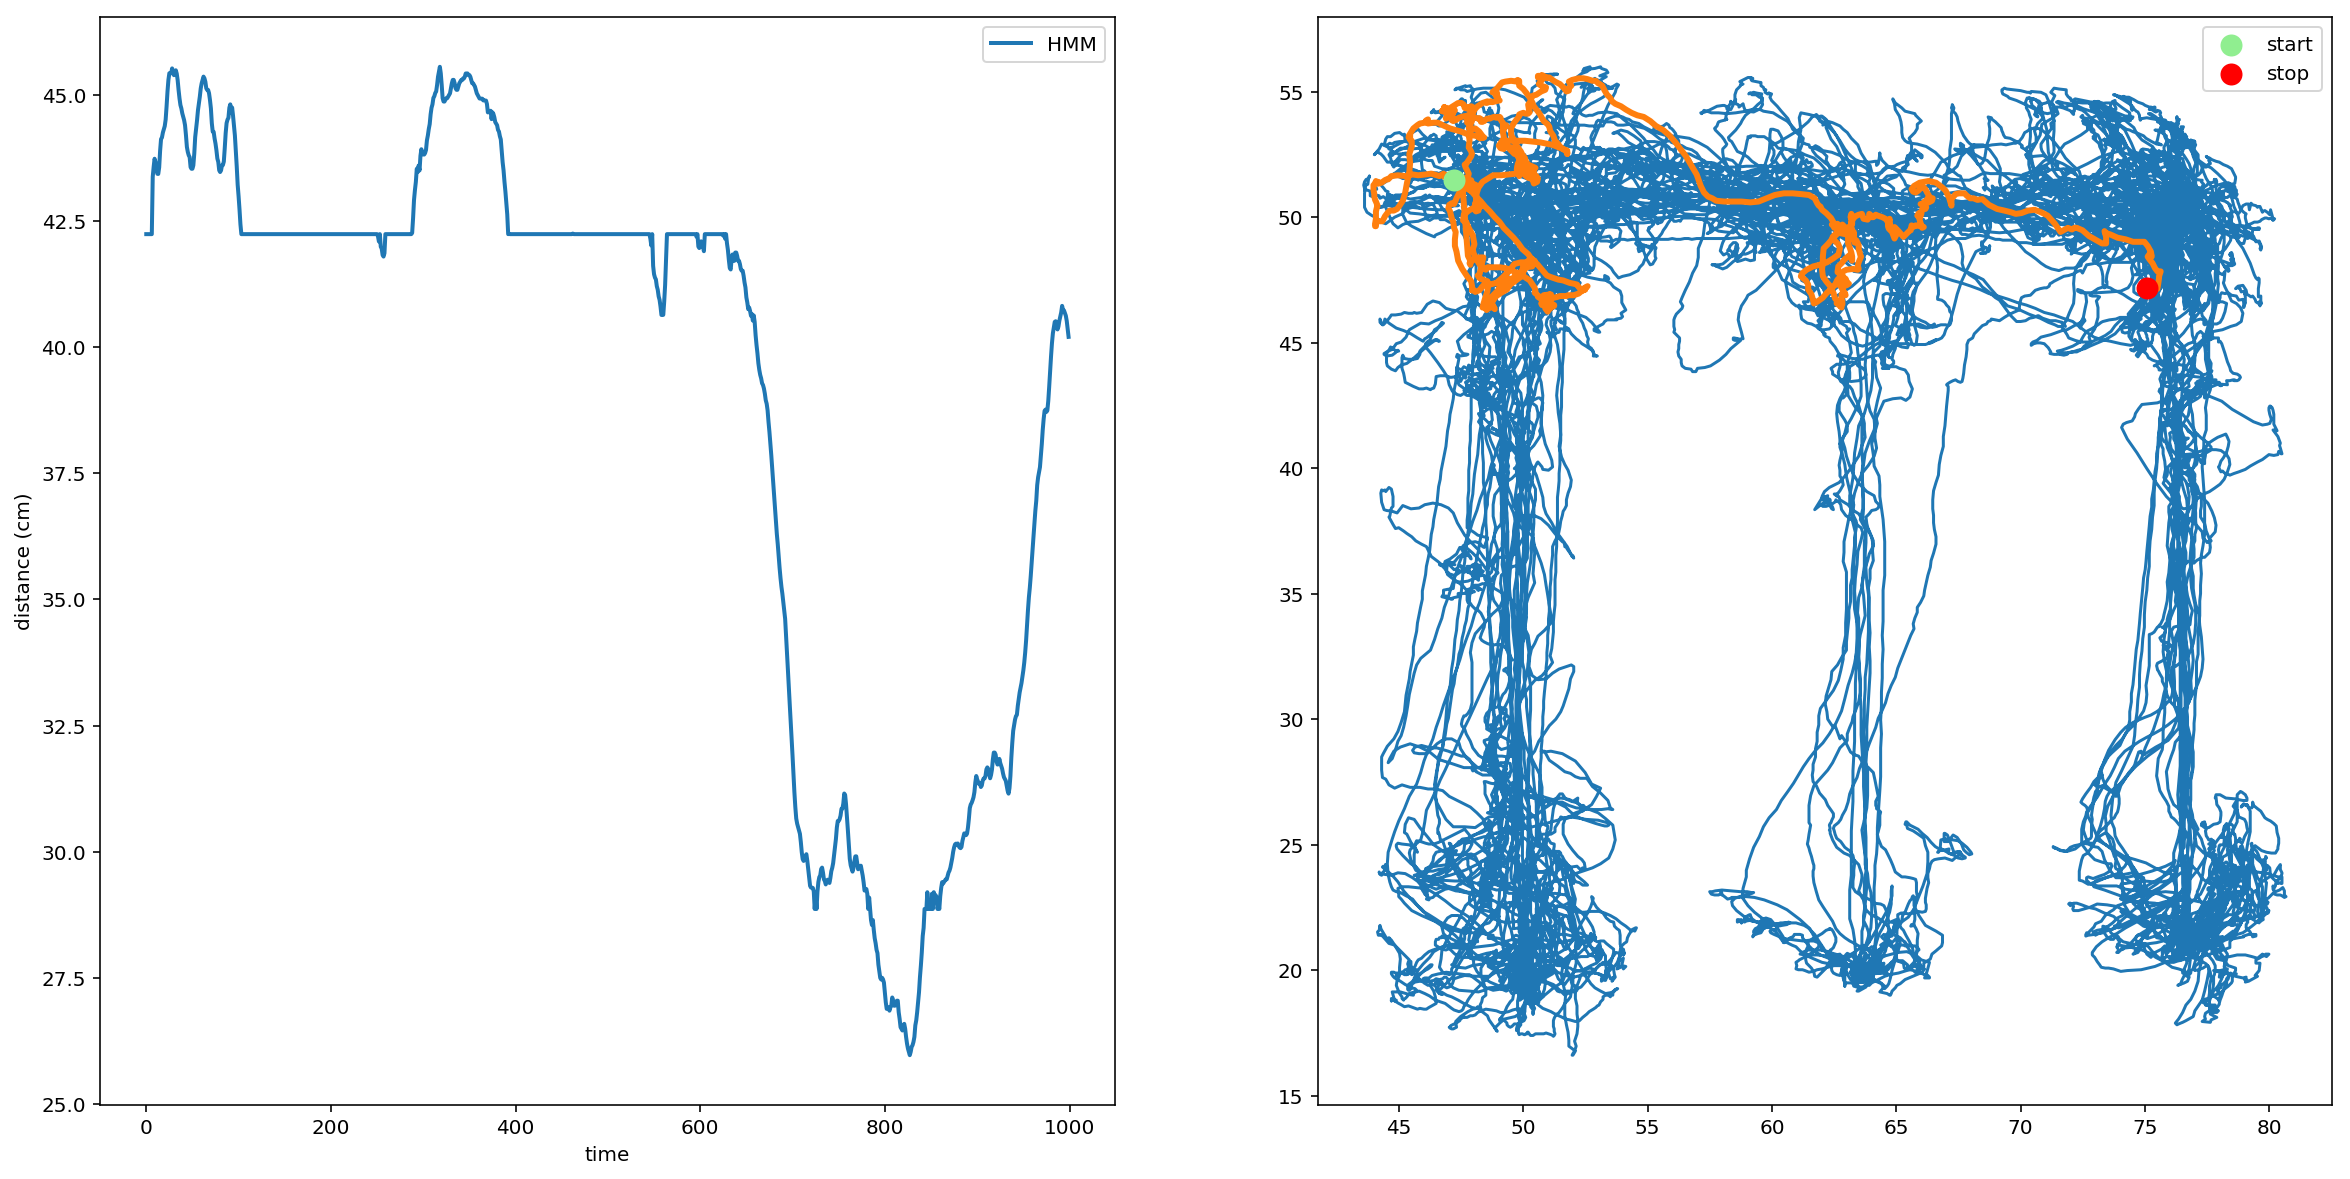

In [145]:
def plot_linear_distance(linear_distance, position, indices):
    time_ind = slice(*indices)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].plot(linear_distance[time_ind], linewidth=2, label='HMM')
    axes[0].set_xlabel('time')
    axes[0].set_ylabel('distance (cm)')
    axes[0].legend();
    
    axes[1].plot(position[:, 0], position[:, 1])
    axes[1].plot(position[time_ind][:, 0], position[time_ind][:, 1],
                 linewidth=3)
    start_stop = position[time_ind][[0, -1], :]
    axes[1].scatter(start_stop[0, 0], start_stop[0, 1],
                    label='start', color='lightgreen', s=100, zorder=1000)
    axes[1].scatter(start_stop[1, 0], start_stop[1, 1],
                    label='stop', color='red', s=100, zorder=1000)
    axes[1].legend()
    
    
plot_linear_distance(linear_distance, position, (0, 1000))

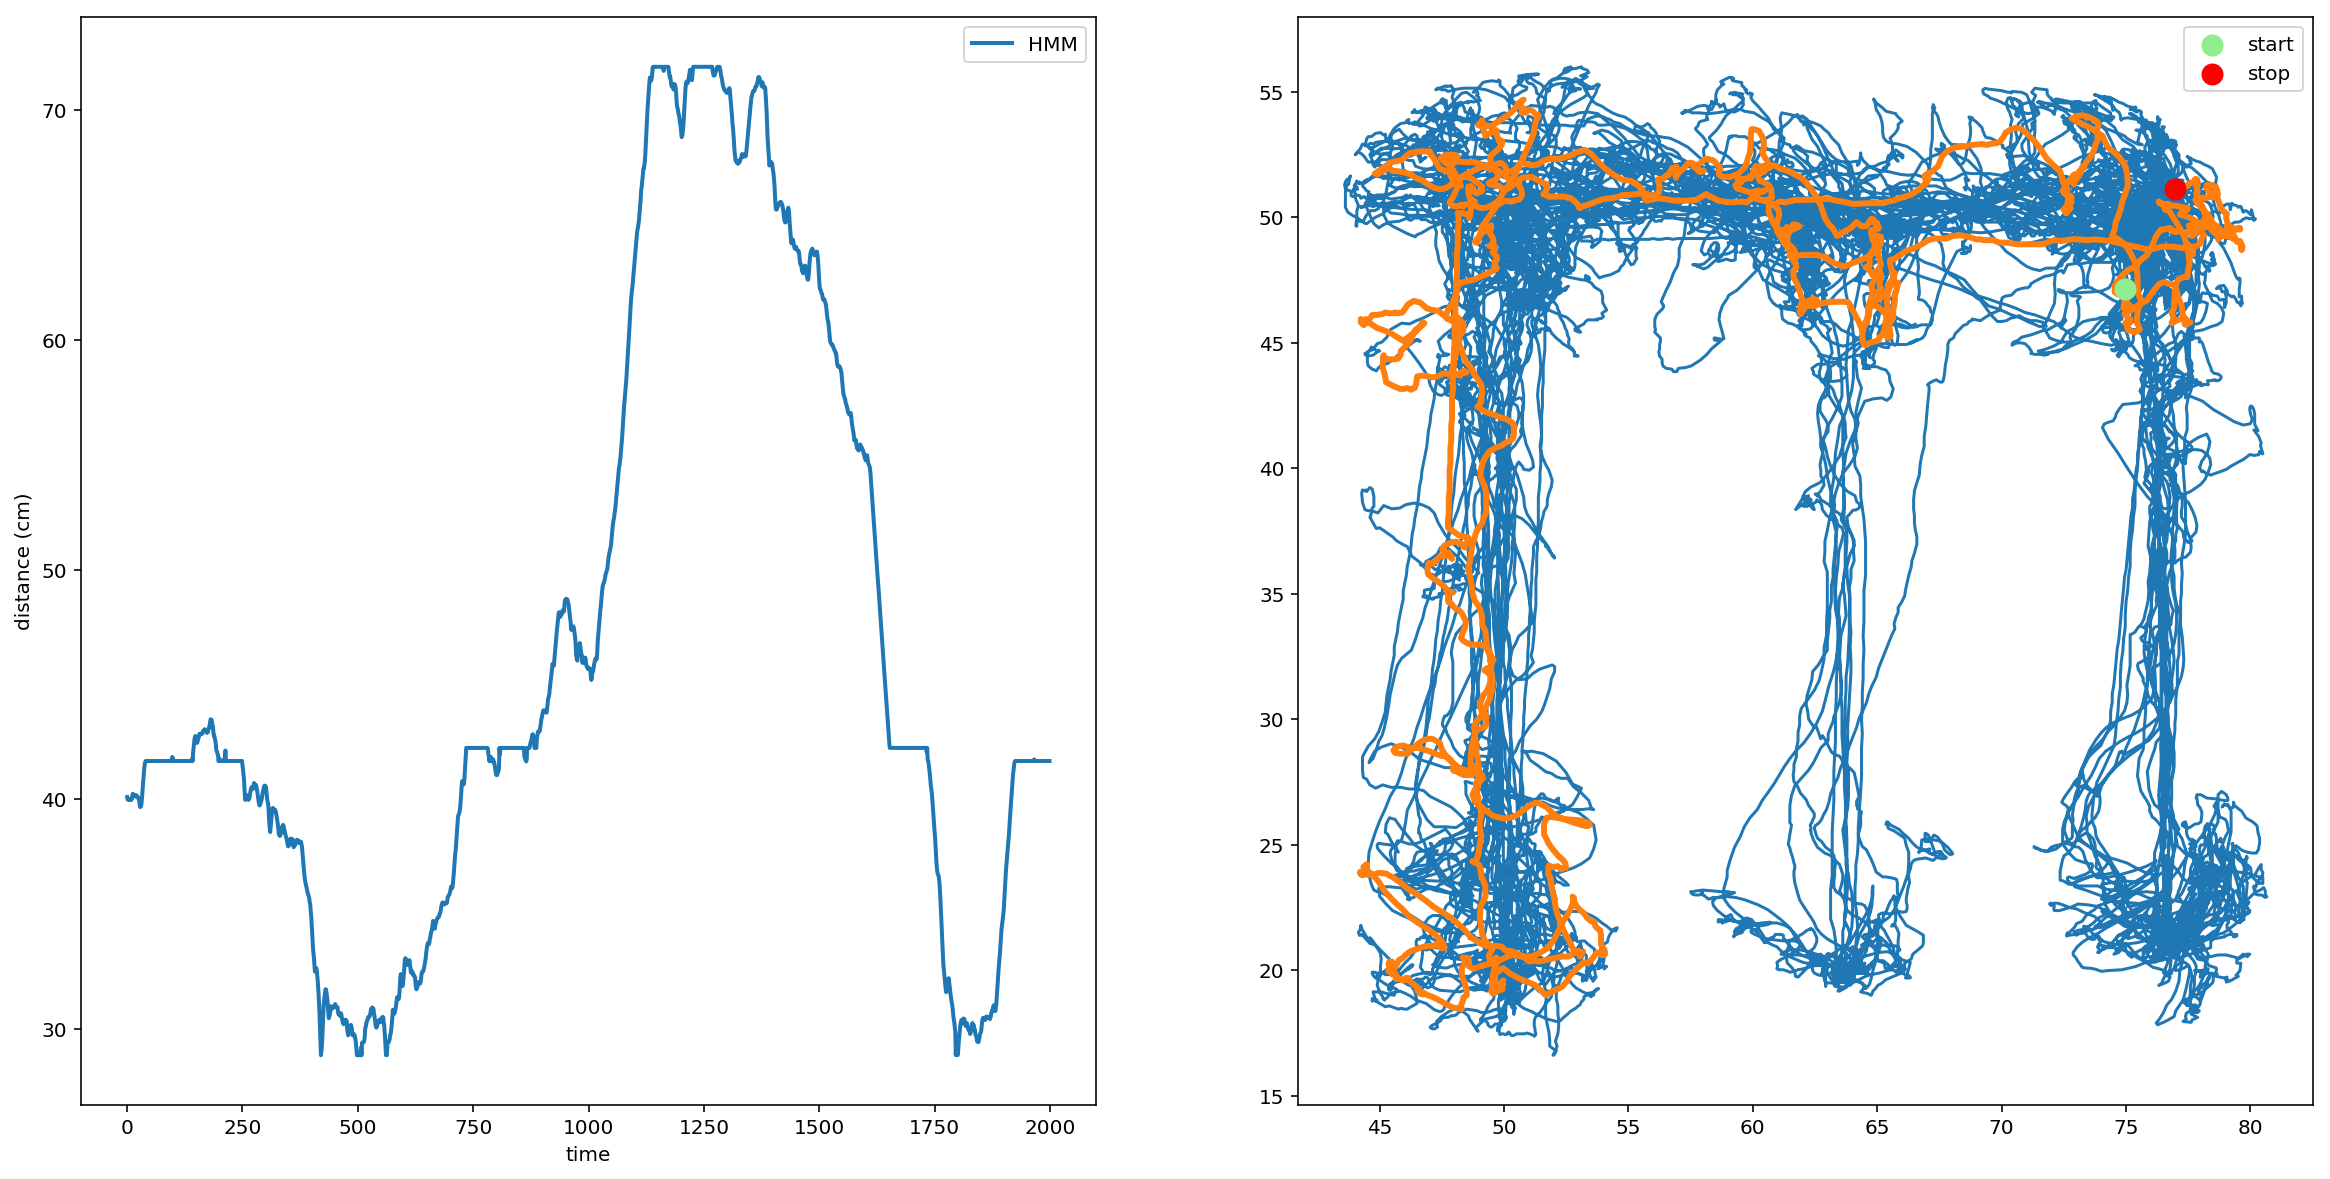

In [146]:
plot_linear_distance(linear_distance, position, (1000, 3000))

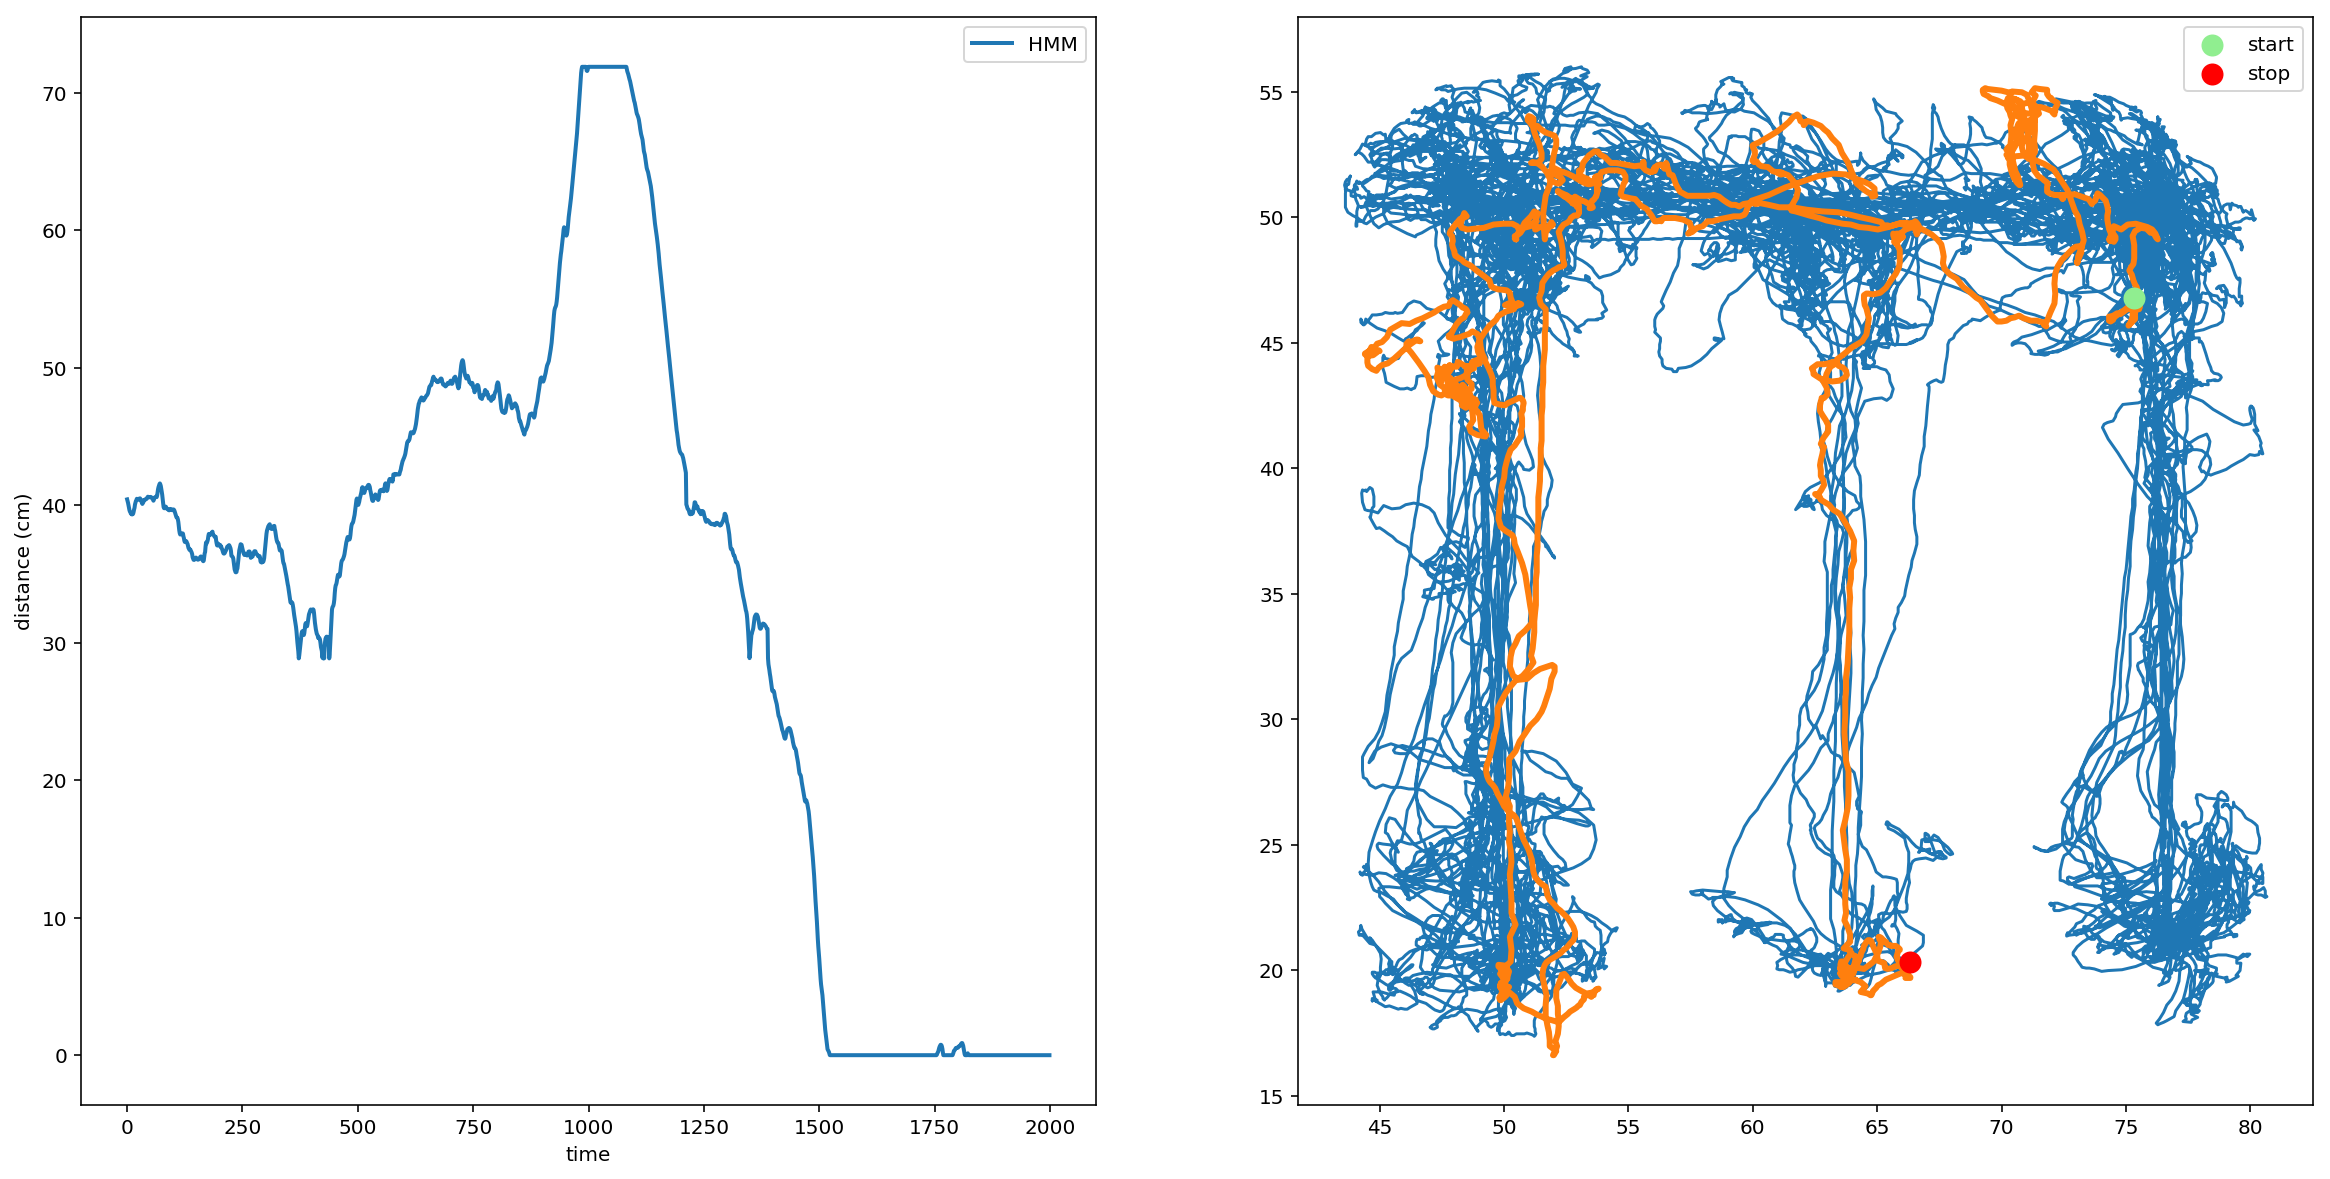

In [153]:
plot_linear_distance(linear_distance, position, (15000, 17000))

## Tetrode Data

Make sure we can get information about the tetrode locations

In [10]:
tetrode_info = lfdp.make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
tetrode_info

area  depth  nchans  numcells   ref subarea  \
animal day epoch tetrode_number                                               
JZ1    1   2     1               mec      0       4         0  11.0       2   
                 2               mec      0       4         0  11.0       5   
                 3               mec      0       8         0  11.0       5   
                 4               mec      0       4         0  11.0       6   
                 5               sub      0       4         0  11.0       d   
                 6               mec      0       4         0  11.0       6   
                 7               mec      0       4         0  11.0       5   
                 8               mec      0       4         0  11.0       2   
                 9               mec      0       4         0  11.0       2   
                 10              mec      0       8         0  11.0       3   
                 11              ref      0       4         0   NaN           
                 12              v2l      0       4         0  11.0       6   
                 13              por      0       4         0  11.0       6   
                 14              mec      0       4         0  11.0       6   
                 15              por      0       4         0  11.0       6   
                 16              ca1      0       4         0  11.0       d   
                 17              ca1      0       4         0  11.0       d   
                 18              ca1      0       4         0  11.0       d   
                 19              ca1      0       4         0  11.0       d   
                 20              ca1      0       4         0  11.0       d   
                 21              ca1      0       4         0  11.0       d   
                 22              ca1      0       4         0  11.0       d   
                 23              ca1      0       4         0  11.0       d   
                 24              ca1      0       4         0  11.0       d   
                 25              ca1      0       4         0  11.0       d   
                 26              ca1      0       4         0  11.0       d   
                 27              ca1      0       4         0  11.0       d   
                 28              ca1      0       4         0  11.0       d   
                 29              ca1      0       4         0  11.0       d   
                 30              ca1      0       4         0  11.0       d   

                                suparea animal  day  epoch  tetrode_number  \
animal day epoch tetrode_number                                              
JZ1    1   2     1                  ctx    JZ1    1      2               1   
                 2                  ctx    JZ1    1      2               2   
                 3                  ctx    JZ1    1      2               3   
                 4                  ctx    JZ1    1      2               4   
                 5                  hpc    JZ1    1      2               5   
                 6                  ctx    JZ1    1      2               6   
                 7                  ctx    JZ1    1      2               7   
                 8                  ctx    JZ1    1      2               8   
                 9                  ctx    JZ1    1      2               9   
                 10                 ctx    JZ1    1      2              10   
                 11                        JZ1    1      2              11   
                 12                 ctx    JZ1    1      2              12   
                 13                 ctx    JZ1    1      2              13   
                 14                 ctx    JZ1    1      2              14   
                 15                 ctx    JZ1    1      2              15   
                 16                 hpc    JZ1    1      2              16   
                 17                 hpc    JZ1    1      2              17   
                 18  

## Detect Ripples

Make sure we can detect ripples

In [15]:
is_brain_areas = tetrode_info.area.isin(['ca1'])
tetrode_keys = tetrode_info[is_brain_areas].index.tolist()

LFPs = [lfdp.get_LFP_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in tetrode_keys]

tetrode_info[is_brain_areas].loc[:, ['area']]

area
animal day epoch tetrode_number     
JZ1    1   2     16              ca1
                 17              ca1
                 18              ca1
                 19              ca1
                 20              ca1
                 21              ca1
                 22              ca1
                 23              ca1
                 24              ca1
                 25              ca1
                 26              ca1
                 27              ca1
                 28              ca1
                 29              ca1
                 30              ca1

In [17]:
hippocampus_lfps = pd.concat(
    [lfdp.get_LFP_dataframe(tetrode_key, ANIMALS)
     for tetrode_key in tetrode_keys], axis=1, keys=tetrode_keys).astype(float).resample('1ms').mean().dropna()
time = hippocampus_lfps.index

def _time_function(epoch_key, animals):
    return time

speed = lfdp.get_interpolated_position_dataframe(
    epoch_key, ANIMALS, _time_function).speed

sampling_frequency = 1000

ripple_times = ripple_detection.Kay_ripple_detector(
        time, hippocampus_lfps.values, speed.values, sampling_frequency,
        minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=3)

In [18]:
ripple_times.head()

start_time        end_time
ripple_number                                
1             00:28:03.734200 00:28:03.823200
2             00:28:04.381200 00:28:04.440200
3             00:28:07.084200 00:28:07.137200
4             00:28:08.581200 00:28:08.683200
5             00:28:09.428200 00:28:09.505200

##  Ripple Power

Make sure we get ripple band power for detected ripples.

In [33]:
window_offset = (-0.5, 0.5)

ripple_locked_LFPs = lfdp.reshape_to_segments(hippocampus_lfps, ripple_times, window_offset=window_offset)
data = (ripple_locked_LFPs.to_panel().to_xarray().transpose('minor_axis', 'major_axis', 'items').values)
m = spectral_connectivity.Multitaper(
    data, sampling_frequency, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=window_offset[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
ripple_locked_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)


In [34]:
m = spectral_connectivity.Multitaper(
    hippocampus_lfps.values, sampling_frequency, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=hippocampus_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')


INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=5)


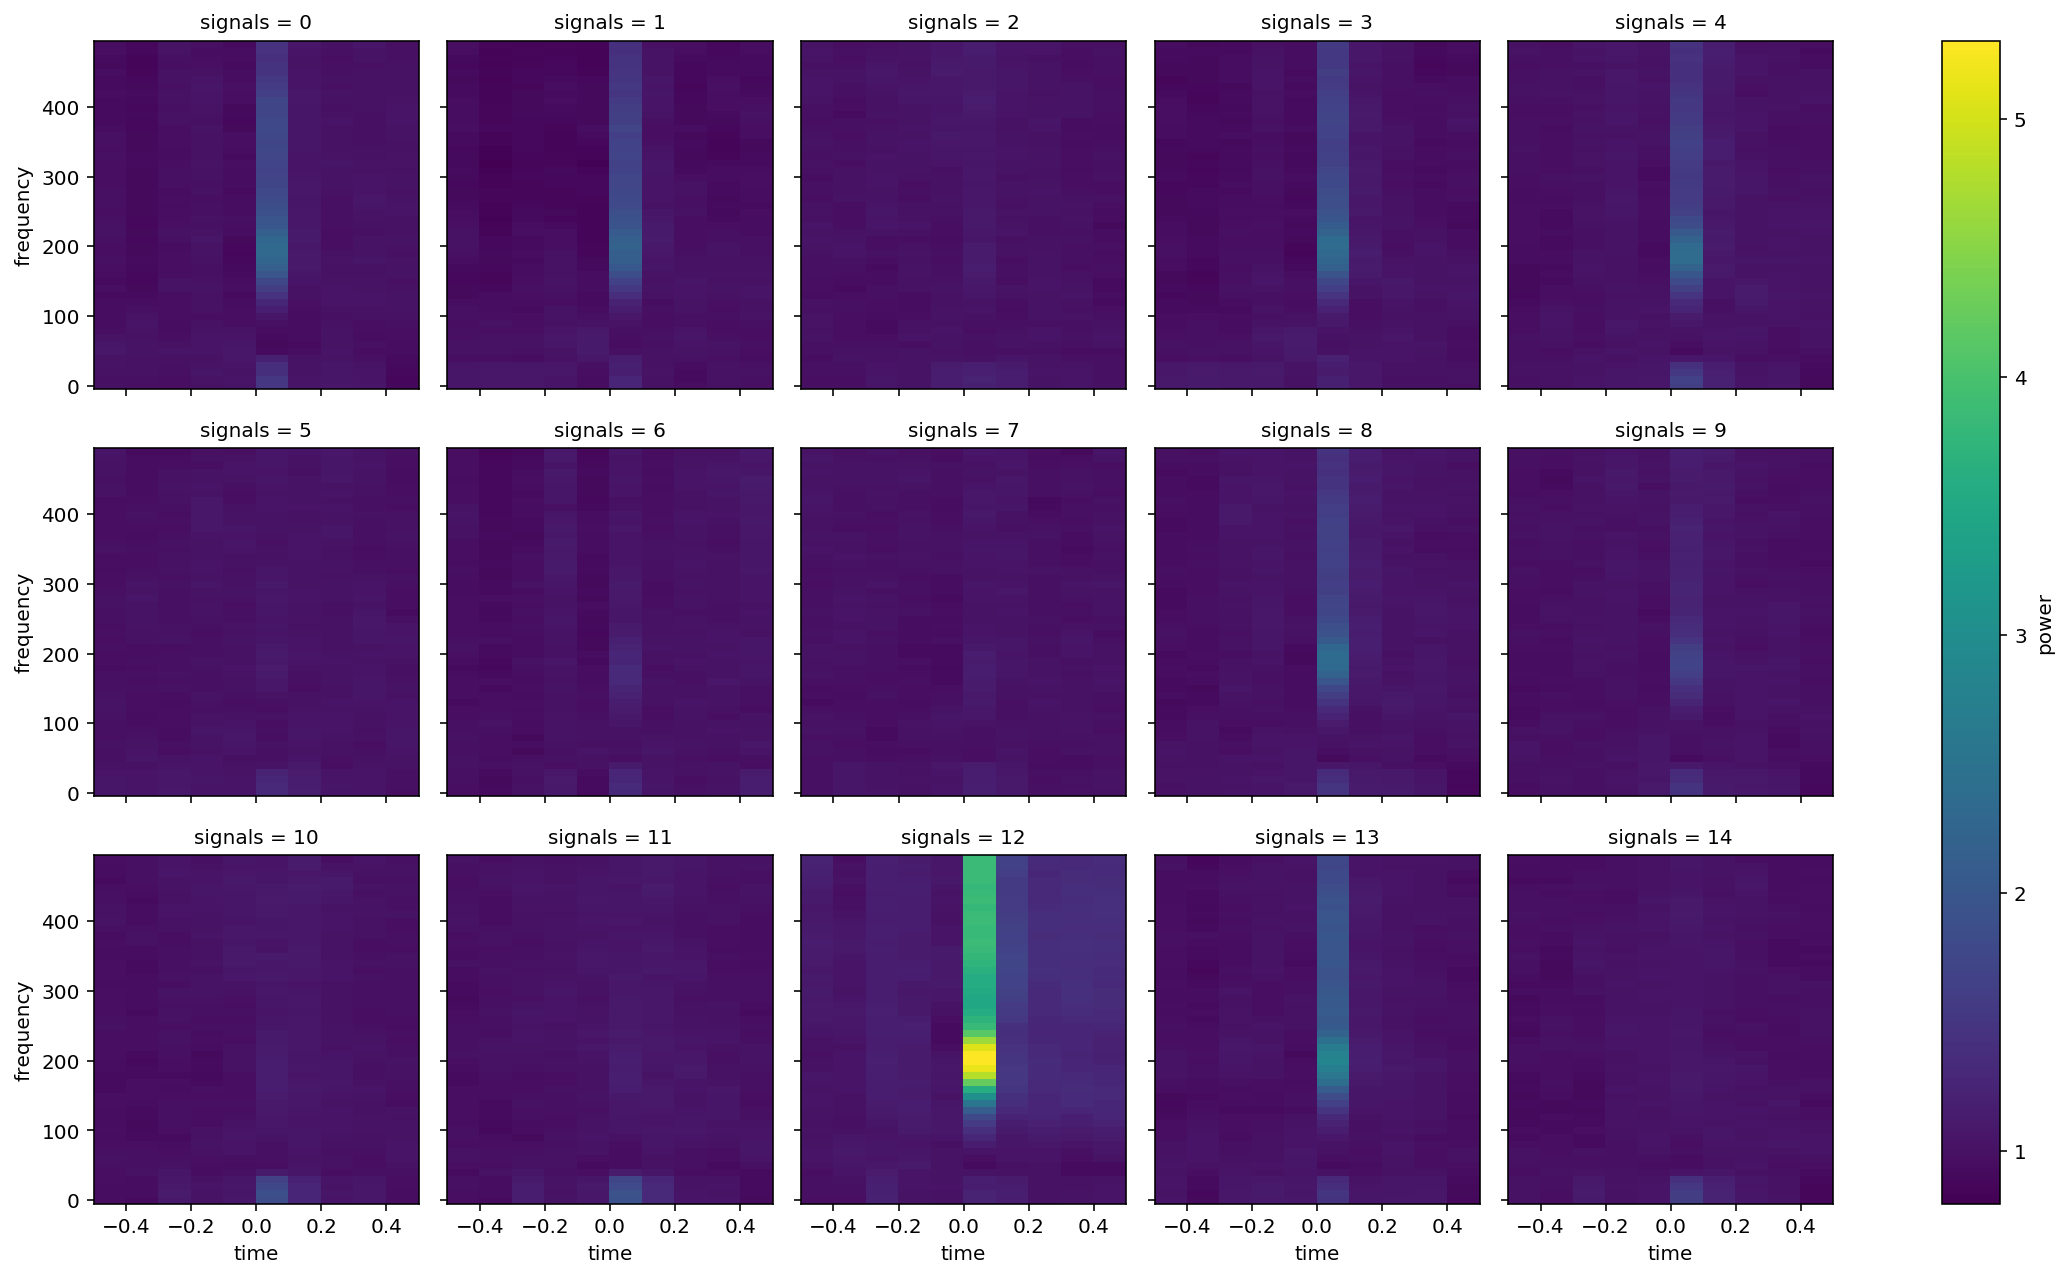

In [41]:
(ripple_locked_power / power.mean('time')).sel(frequency=slice(0, 500)).plot(
    x='time', y='frequency', col='signals', col_wrap=5);

In [42]:
ripple_duration = ripple_times.end_time.dt.total_seconds() - ripple_times.start_time.dt.total_seconds()

In [43]:
ripple_filtered_LFPs = pd.DataFrame(
    np.stack([ripple_detection.filter_ripple_band(lfp, sampling_frequency)
              for lfp in hippocampus_lfps.values.T], axis=1),
    index=time, columns=tetrode_keys)

ripple_locked_filtered_LFPs = lfdp.reshape_to_segments(
    ripple_filtered_LFPs, ripple_times, window_offset=window_offset)

In [75]:
m = spectral_connectivity.Multitaper(hippocampus_lfps.values, sampling_frequency, time_window_duration=0.020,
                                     time_window_step=0.004,
               time_halfbandwidth_product=1, start_time=time.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
ripple_power = xr.DataArray(c.power(), dims=('time', 'frequency', 'signals'),
                            coords=dict(time=pd.TimedeltaIndex(c.time, unit='s'), frequency=c.frequencies), name='power')
ripple_power = ripple_power.sel(frequency=200).reindex(time)
ripple_power /= ripple_power.mean('time')
ripple_locked_power = lfdp.reshape_to_segments(ripple_power.drop('frequency').to_dataframe().unstack(), ripple_times, window_offset)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.004,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=1)


In [76]:
from ipywidgets import interact

ripple_time = ripple_locked_LFPs.unstack(level=0).index.get_level_values('time').total_seconds().values

def plot_lfp(ripple_number=1):
    n_LFPs = hippocampus_lfps.shape[1]
    fig, axes = plt.subplots(n_LFPs, 3, figsize=(20, 10), sharex=True)
    for ax, lfp in zip(
            axes[:, 0], ripple_locked_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp)
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    for ax, lfp in zip(
            axes[:, 1], ripple_locked_filtered_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp, color='orange')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    power_time = ripple_locked_power.loc[ripple_number].index.total_seconds().values
    for ax, p in zip(axes[:, 2], ripple_locked_power.loc[ripple_number].values.T):
        ax.plot(power_time, p, color='purple')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(1, color='black', linestyle='--')

    axes[0, 0].set_title('LFP')
    axes[0, 1].set_title('Bandpass Filtered LFP (150 - 250 Hz)')
    axes[0, 2].set_title('Ripple Power Change');

n_ripples = len(ripple_times)
interact(plot_lfp, ripple_number=(1, n_ripples), continuous_update=False);

interactive(children=(IntSlider(value=1, description='ripple_number', max=372, min=1), Output()), _dom_classes=('widget-interact',))

## Theta Power

Make sure there is hippocampal theta present

In [99]:
m = spectral_connectivity.Multitaper(
    hippocampus_lfps.values, sampling_frequency, time_window_duration=3.000,
    time_halfbandwidth_product=3, start_time=hippocampus_lfps.index.total_seconds()[0])
c = spectral_connectivity.Connectivity.from_multitaper(m)
theta_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.500, frequency=c.frequencies), name='power')
m.frequency_resolution

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=3,
           time_window_duration=3.0, time_window_step=3.0,
           detrend_type='constant', start_time=1680.0852000000002, n_tapers=5)


1.0

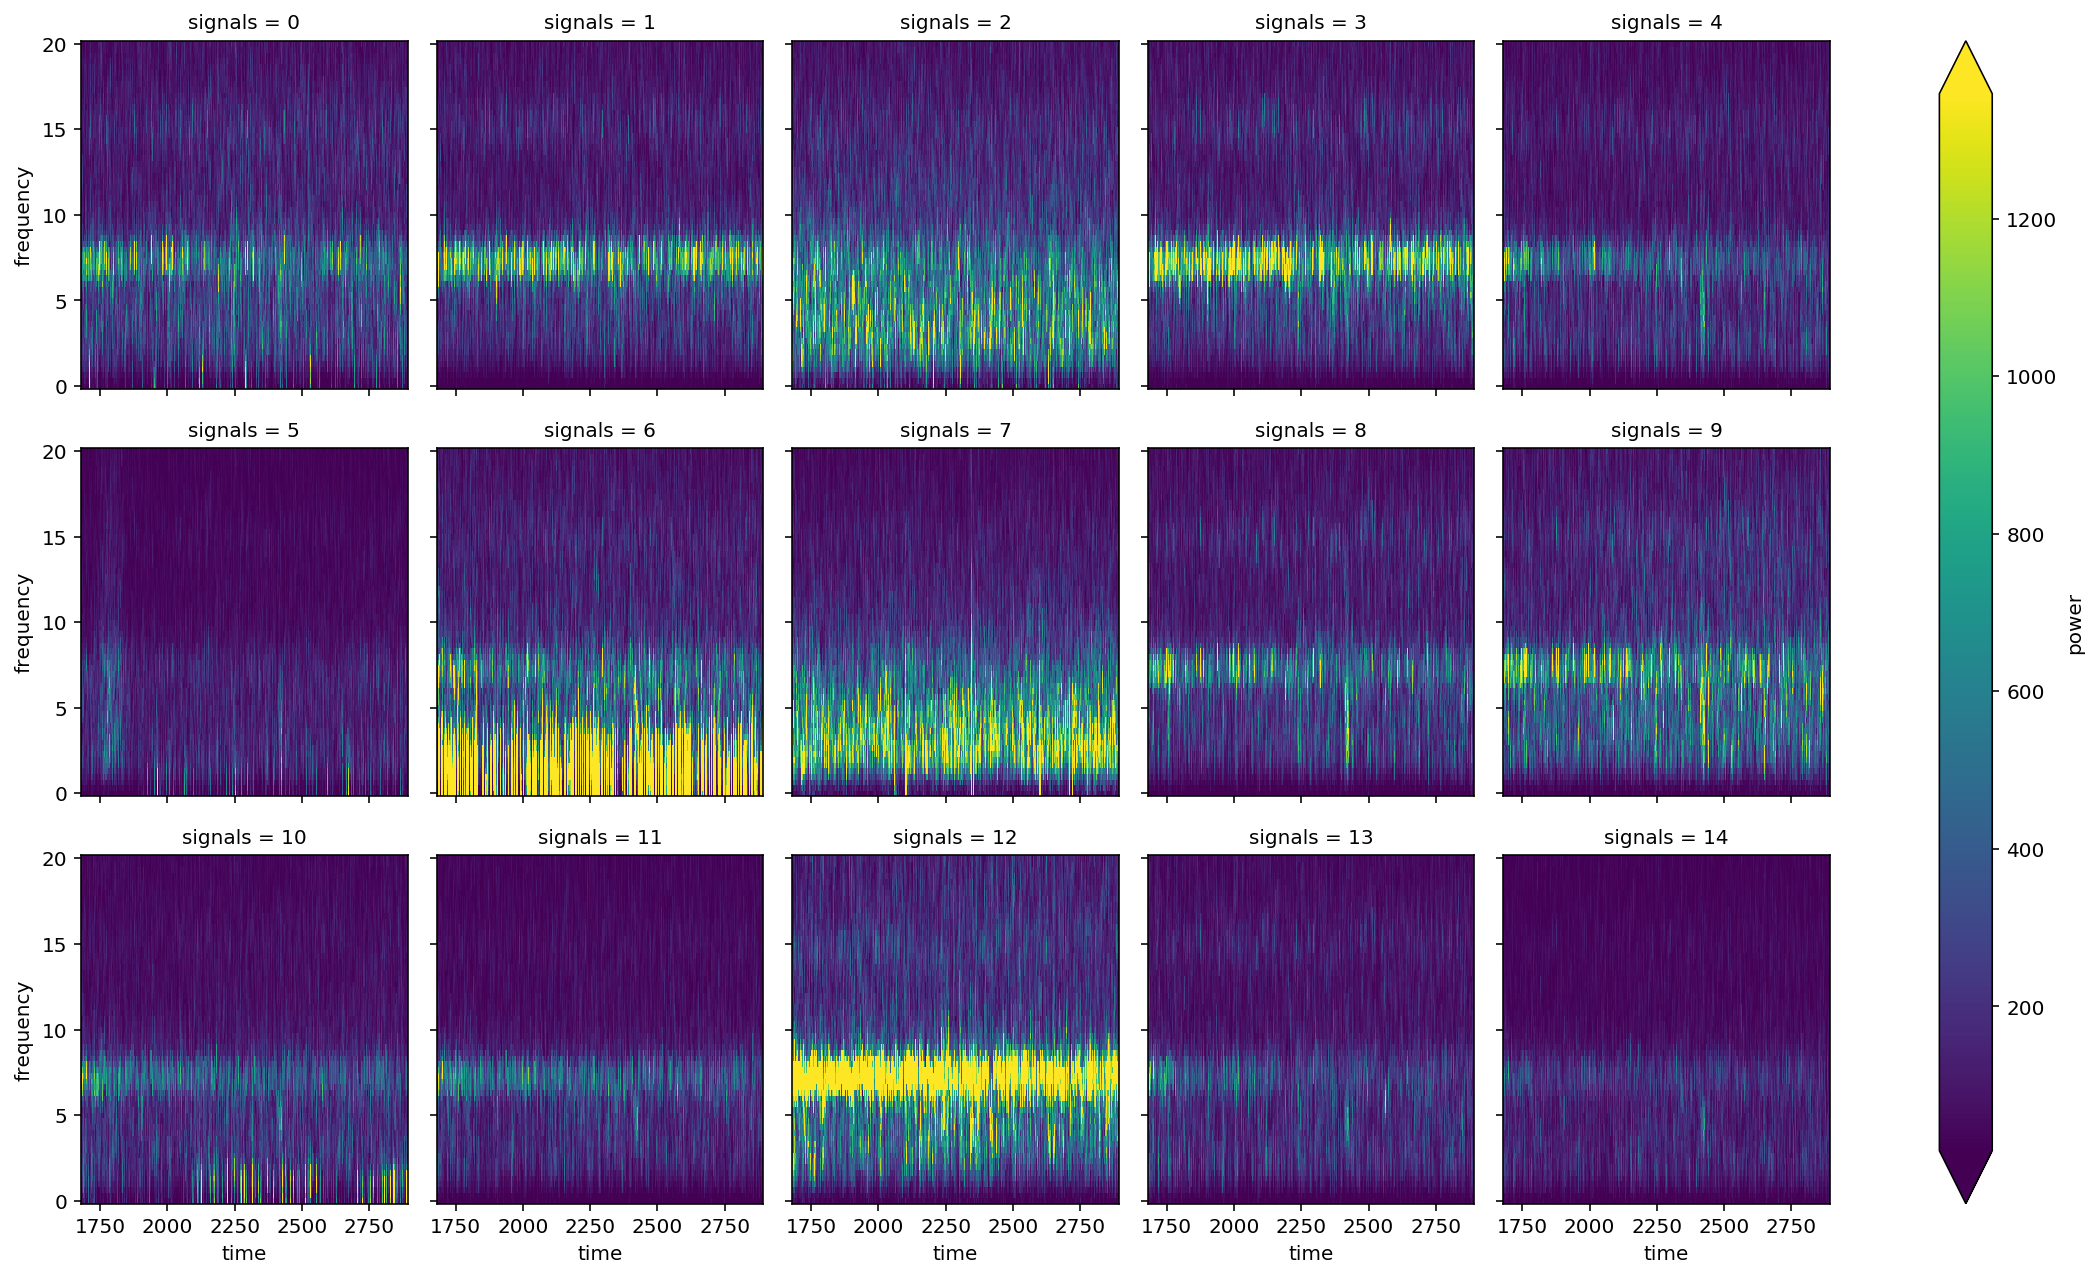

In [100]:
theta_power.sel(frequency=slice(0, 20)).plot(x='time', y='frequency', col='signals', col_wrap=5, robust=True);

## Neurons

Make sure we can get information about single units

In [101]:
neuron_info = lfdp.make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info

meanrate  neuron_number  \
animal day epoch tetrode_number neuron_number                                 
JZ1    1   2     2              1                 345.662322              1   
                 3              1                 172.831161              1   
                 10             1                7044.927323              1   
                                2                4049.187200              2   
                 12             1                  82.300553              1   
                 13             1               33175.352850              1   
                 14             1                   8.230055              1   
                                2                   0.000000              2   
                                3                   0.000000              3   
                                4                 106.990719              4   
                 16             1                   8.230055              1   
                                2                1201.588071              2   
                                3                6682.804891              3   
                                4              474372.156516              4   
                 17             1               21389.913683              1   
                                2                6584.044227              2   
                 20             1                   8.230055              1   
                                2                 658.404423              2   
                                3                 197.521327              3   
                 24             1               19562.841410              1   
                 26             1                   8.230055              1   
                 27             1               88440.174082              1   
                                2              252498.096114              2   
                 28             1               33907.827770              1   
                                2               96011.824943              2   
                                3               17875.680077              3   
                                4               16056.837859              4   
                                5               21719.115895              5   
                                6               35060.035510              6   
                                7               10756.682256              7   
                                8               19291.249586              8   
                                9                9423.413300              9   

                                               numspikes  spikewidth  \
animal day epoch tetrode_number neuron_number                          
JZ1    1   2     2              1                     42         NaN   
                 3              1                     21         NaN   
                 10             1                    856         NaN   
                                2                    492         NaN   
                 12             1                     10         NaN   
                 13             1                   4031         NaN   
                 14             1                      1         NaN   
                                2                      0         NaN   
                                3                      0         NaN   
                                4                     13         NaN   
                 16             1                      1         NaN   
                                2                    146         NaN   
                                3                    812         NaN   
                                4                  57639         NaN   
                 17             1                   2599         NaN   
                                2                    800         NaN   
                 20             1                      1         NaN 

In [103]:
neuron_key = ('JZ1', 1, 2, 2, 1)
lfdp.get_spike_indicator_dataframe(neuron_key, ANIMALS)

NotImplementedError: Please use HDF reader for matlab v7.3 files

## Multiunit Data

In [104]:
tetrode_key = ('JZ1', 1, 2, 16)
lfdp.get_multiunit_indicator_dataframe(tetrode_key, ANIMALS)

TypeError: 'NoneType' object is not iterable

## DIO